<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_8%5DAnalyzing_the_Sensibility_of_Film_Review_Texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. pip 설치 및 import




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://sanghyu.tistory.com/170

In [2]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Ign:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 252 kB in 2s (119 kB/s)
Reading package li

In [3]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [4]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /tmp/mecab-python-0.996
  Created wheel for mecab-python: filename=mecab_python-0.996_ko_0.9.2-cp37-cp37m-linux_x86_64.whl size=141801 sha256=432a71b33640bd7bd69dfe8fc20463b7f4ff530825de9dcc80b7d035ef01836b
  Stored in directory: /root/.cache/pip/wheels/40/7b/9f/2922869bef86c3354ae7034f7a3647c573ee1997c2dad0290a
Failed to build mecab-python
  Attempting uninstall: mecab-python
    Found existing installation: mecab-python 0.996-ko-0.9.2
    Uninstalling mecab-python-0.996-ko-0.9.2:
      Successfully uninstalled mecab-python-0.996-ko-0.9.2
    Running setup.py install for mecab-python: started
    Running setup.py install for mecab-python: finished with status 'done'


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  DEPRECATION: mecab-python was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [5]:
import pandas as pd
import konlpy
import gensim
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf


In [6]:
print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.5
0.6.0
3.6.0


## 2. 데이터 준비와 확인

In [7]:
base_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/영화텍스트감성분석"
train_data = pd.read_table(base_path+'/ratings_train.txt')
test_data = pd.read_table(base_path+'/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 3. 데이터로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.


데이터의 중복 제거

NaN 결측치 제거

한국어 토크나이저로 토큰화

불용어(Stopwords) 제거

사전word_to_index 구성

텍스트 스트링을 사전 인덱스 스트링으로 변환

X_train, y_train, X_test, y_test, word_to_index 리턴

In [8]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 


In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [11]:
for i in range(10):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('라벨: ', y_train[i])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0
[1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]
. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
라벨:  1
[24, 205, 2]
재 <UNK>
라벨:  0
[8410, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]
이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정
라벨:  0
[2, 8894, 1108, 52, 2832, 60, 5, 14, 2758, 41, 1188, 35, 351, 42, 22, 40, 60, 2, 2, 427, 3102, 1766, 6]
익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
라벨:  1
[675, 2, 2, 131, 420, 185, 1547, 712, 65, 1694, 715, 53, 375, 192, 271, 5, 4, 69, 4, 11, 2179, 122, 750, 4]
<UNK> <UNK> 3 세 부터 초등 학교 1 학년 생 인 8 살 용 영화 . ㅋㅋㅋ . .. 별반 개 아까움 .
라벨:  0
[253, 381, 9, 384, 2012, 55, 15, 817, 6, 4]
긴장감 을 제대로 살려 내 지 못했 다 .
라벨:  0
[232, 1450, 144, 6, 425, 756, 2, 2, 52, 1532, 290, 99, 250, 4, 4, 28, 855, 29, 353, 652, 540, 509, 583, 6, 3318, 4, 8895, 22, 1460, 1460, 4, 4, 71, 304, 17, 6, 52, 104, 8, 77, 22, 2, 43]
반개 아깝 다 욕 나온다 <UNK> <UNK> 연기 생활 몇 년 인지 . . 정말 발 로 해도 그

## 4. 모델 구성을 위한 데이터 분석 및 가공

데이터셋 내 문장 길이 분포

적절한 최대 문장 길이 지정

keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [12]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [13]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [14]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969355837799927
문장길이 최대 :  116
문장길이 표준편차 :  12.843536204665021
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [15]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 5. 모델 구성 및 validation set 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

### 1) LSTM




In [16]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 20  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          200000    
                                                                 
 lstm (LSTM)                 (None, 8)                 928       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 201,009
Trainable params: 201,009
Non-trainable params: 0
_________________________________________________________________


### 2) CNN

In [17]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 20   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 20)          200000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          2256      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

### 3) GlobalMaxPooling1D()

In [18]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 20   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 20)          200000    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 20)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 168       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 200,177
Trainable params: 200,177
Non-trainable params: 0
_________________________________________________________________


In [19]:
# validation set 10000건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


## 6. 모델 훈련 개시

### 1) LSTM

In [20]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 5s 11ms/step - loss: 0.5536 - accuracy: 0.7351 - val_loss: 0.4169 - val_accuracy: 0.8366
Epoch 2/20
188/188 [==============================] - 2s 8ms/step - loss: 0.3735 - accuracy: 0.8503 - val_loss: 0.3636 - val_accuracy: 0.8469
Epoch 3/20
188/188 [==============================] - 2s 8ms/step - loss: 0.3306 - accuracy: 0.8652 - val_loss: 0.3586 - val_accuracy: 0.8447
Epoch 4/20
188/188 [==============================] - 2s 8ms/step - loss: 0.3152 - accuracy: 0.8714 - val_loss: 0.3597 - val_accuracy: 0.8446
Epoch 5/20
188/188 [==============================] - 2s 8ms/step - loss: 0.3047 - accuracy: 0.8762 - val_loss: 0.3642 - val_accuracy: 0.8439
Epoch 6/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2975 - accuracy: 0.8797 - val_loss: 0.3660 - val_accuracy: 0.8425
Epoch 7/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2903 - accuracy: 0.8837 - val_loss: 0.3660 - val_accuracy: 0.8454
Epoch

In [21]:
results = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4670 - accuracy: 0.8312 - 4s/epoch - 3ms/step
[0.46695321798324585, 0.8312346339225769]


### 2) CNN

In [22]:
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 3s 8ms/step - loss: 0.5208 - accuracy: 0.7348 - val_loss: 0.3621 - val_accuracy: 0.8407
Epoch 2/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3347 - accuracy: 0.8560 - val_loss: 0.3451 - val_accuracy: 0.8496
Epoch 3/20
188/188 [==============================] - 1s 7ms/step - loss: 0.2984 - accuracy: 0.8754 - val_loss: 0.3424 - val_accuracy: 0.8504
Epoch 4/20
188/188 [==============================] - 1s 7ms/step - loss: 0.2724 - accuracy: 0.8885 - val_loss: 0.3481 - val_accuracy: 0.8504
Epoch 5/20
188/188 [==============================] - 1s 7ms/step - loss: 0.2456 - accuracy: 0.9030 - val_loss: 0.3566 - val_accuracy: 0.8499
Epoch 6/20
188/188 [==============================] - 1s 7ms/step - loss: 0.2135 - accuracy: 0.9186 - val_loss: 0.3719 - val_accuracy: 0.8488
Epoch 7/20
188/188 [==============================] - 1s 7ms/step - loss: 0.1810 - accuracy: 0.9343 - val_loss: 0.4061 - val_accuracy: 0.8414
Epoch 

In [23]:
results = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4670 - accuracy: 0.8312 - 5s/epoch - 3ms/step
[0.46695321798324585, 0.8312346339225769]


### 3) GlobalMaxPooling1D()

In [24]:
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gmp = model_gmp.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 2s 6ms/step - loss: 0.6118 - accuracy: 0.7509 - val_loss: 0.4654 - val_accuracy: 0.8129
Epoch 2/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3961 - accuracy: 0.8342 - val_loss: 0.3705 - val_accuracy: 0.8365
Epoch 3/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3325 - accuracy: 0.8598 - val_loss: 0.3551 - val_accuracy: 0.8432
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2993 - accuracy: 0.8750 - val_loss: 0.3528 - val_accuracy: 0.8455
Epoch 5/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2749 - accuracy: 0.8871 - val_loss: 0.3571 - val_accuracy: 0.8470
Epoch 6/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2551 - accuracy: 0.8975 - val_loss: 0.3642 - val_accuracy: 0.8456
Epoch 7/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2381 - accuracy: 0.9053 - val_loss: 0.3743 - val_accuracy: 0.8440
Epoch 

In [25]:
results = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4670 - accuracy: 0.8312 - 4s/epoch - 3ms/step
[0.46695321798324585, 0.8312346339225769]


## 7. Loss, Accuracy 그래프 시각화

### 1) LSTM

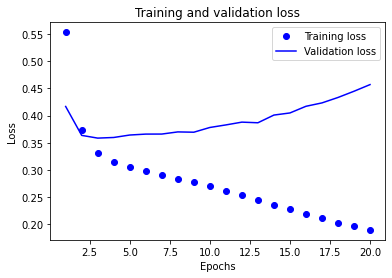

In [26]:
import matplotlib.pyplot as plt

history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


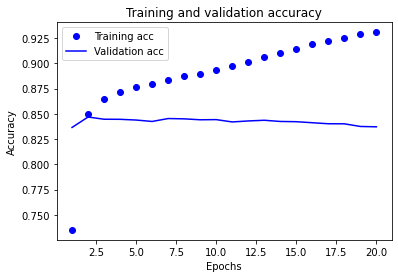

In [27]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 2) CNN

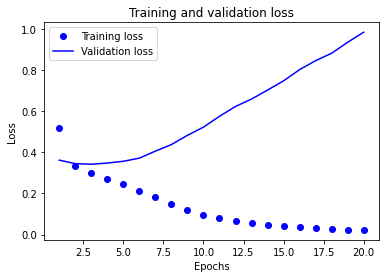

In [28]:
import matplotlib.pyplot as plt

history_dict = history_cnn.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


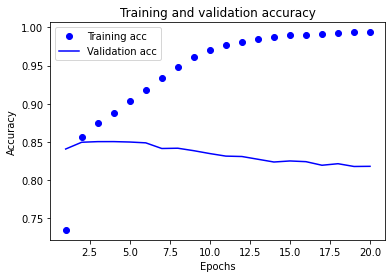

In [29]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### GlobalMaxPooling1D()

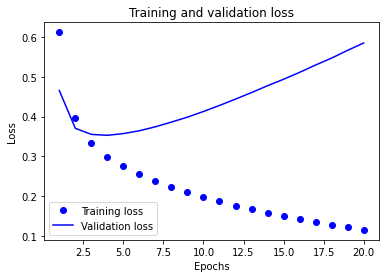

In [30]:
import matplotlib.pyplot as plt

history_dict = history_gmp.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


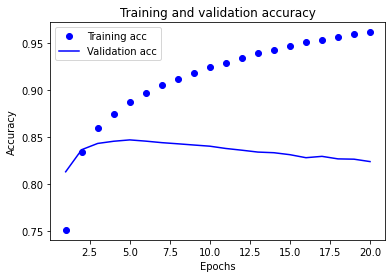

In [31]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 8. 학습된 Embedding 레이어 분석

In [61]:
! pip list | grep gensim

gensim                        3.6.0


### 1) LSTM

In [32]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 20)


In [33]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_lstm = '/content/drive/MyDrive/인공지능/아이펠/ES/data/영화텍스트감성분석/data/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [34]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)
vector = word_vectors['영화']
print(vector)

print(word_vectors.similar_by_word("스릴러"))

[ 0.22939837  0.04705266 -0.01242004 -0.00810441  0.03643418 -0.0516746
  0.03162606  0.04784872 -0.04918906 -0.14405844 -0.10739523  0.1047583
  0.06623012 -0.05358224  0.08525605 -0.02086719 -0.20026307 -0.02281171
 -0.08610898 -0.10079297]
[('냈', 0.906025767326355), ('겠어요', 0.8989001512527466), ('ㅠㅜ', 0.8988913297653198), ('달린다', 0.8962154388427734), ('준다', 0.8920562863349915), ('요', 0.8680625557899475), ('!!!', 0.8628243803977966), ('처음', 0.8570408821105957), ('오히려', 0.8532239198684692), ('했어요', 0.853076159954071)]


### 2) CNN

In [35]:
embedding_layer = model_cnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 20)


In [36]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_cnn = '/content/drive/MyDrive/인공지능/아이펠/ES/data/영화텍스트감성분석/data/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [37]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)
vector = word_vectors['영화']
print(vector)

print(word_vectors.similar_by_word("로맨스"))

[ 0.08306555 -0.08449655  0.03704326 -0.0217507  -0.0355952  -0.07808224
 -0.04992847 -0.0141278   0.04342128 -0.02408633  0.00354727  0.03818154
  0.00198755 -0.02591391  0.01316655  0.01272624 -0.06561277 -0.03195637
  0.03604968  0.05986442]
[('도전', 0.7332847118377686), ('공무원', 0.6584159135818481), ('으다', 0.6272963285446167), ('세용', 0.6124446392059326), ('인', 0.6069444417953491), ('기억', 0.6022626161575317), ('흘린', 0.5954276323318481), ('발리', 0.594045877456665), ('댕', 0.5915261507034302), ('BEST', 0.5856846570968628)]


### 3) GlobalMaxPooling1D()

In [38]:
embedding_layer = model_gmp.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 20)


In [39]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_gmp = '/content/drive/MyDrive/인공지능/아이펠/ES/data/영화텍스트감성분석/data/word2vec_gmp.txt'
f = open(word2vec_file_path_gmp, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_gmp.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [40]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_gmp, binary=False)
vector = word_vectors['영화']
print(vector)

print(word_vectors.similar_by_word("코미디"))

[-0.24510463 -0.28459024 -0.22361495 -0.19057514 -0.2265948  -0.18865441
 -0.2427489  -0.25760671 -0.2747573  -0.23153065 -0.22497961 -0.00924145
 -0.19672598 -0.18480319 -0.26254046 -0.16893747 -0.06481675 -0.2003267
 -0.19254205 -0.1810053 ]
[('너무', 0.9891800880432129), ('을', 0.9874765276908875), ('.', 0.9808175563812256), ('이랑', 0.9776153564453125), ('았', 0.9751890301704407), ('배우', 0.9717732667922974), ('다', 0.971481204032898), ('하', 0.967728853225708), ('고', 0.9672245979309082), ('연출', 0.96715247631073)]


## 9. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [89]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = "/content/drive/MyDrive/error_model/word2vec_ko.model"
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv

In [90]:
vector.similar_by_word("액션")

[('코미디', 0.7429822683334351),
 ('스릴러', 0.7381718754768372),
 ('판타지', 0.6900153160095215),
 ('호러', 0.6892675757408142),
 ('SF', 0.6889280676841736),
 ('롤플레잉', 0.6625269651412964),
 ('영화', 0.6522793769836426),
 ('서스펜스', 0.645000696182251),
 ('어드벤처', 0.6273845434188843),
 ('미스터리', 0.6250677108764648)]

In [92]:
vocab_size = 10000
word_vector_dim = 100

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
n = 0
for i in range(4,vocab_size):
    if index_to_word[i] in vector:
        embedding_matrix[i] = vector[index_to_word[i]]

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_lstm.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid')) 



### 1) LSTM

한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.

한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다

In [ ]:
# # 예시 코드
# from gensim.models.keyedvectors import Word2VecKeyedVectors
# word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
# vector = word_vectors.wv[‘끝’]